# Rand distance and Variation of Information

Let us compare Rand distance with Variation of Information, two metrics for clusterings.

For two clusterings $\mathcal A$ and $\mathcal B$ of the same finite ground set $V$ of cardinality $n$, *Rand distance* is defined as
$$
\text{Rand}(\mathcal A,\mathcal B)=\frac{\#\text{disagreements}}{{n\choose 2}},
$$
where a *disagreement* is a pair $u,v\in V$ of elements that are clustered together in $\mathcal A$ but not in $\mathcal B$, or vice versa.

For the variation of information, we first define the *entropy* of $\mathcal A$
$$
H(\mathcal A)=-\sum_{A\in\mathcal A}\frac{|A|}{n}\log_2\left(\frac{|A|}{n}\right)
$$
and the *joint entropy* of $\mathcal A$ and $\mathcal B$ 
$$
H(\mathcal A,\mathcal B)=-\sum_{A\in\mathcal A,B\in\mathcal B}\frac{|A\cap B|}{n}\log_2\left(\frac{|A\cap B|}{n}\right)
$$
Then the *variation of information* is
$$
\text{VI}(\mathcal A,\mathcal B)=2H(\mathcal A,\mathcal B)-H(\mathcal A)-H(\mathcal B)
$$


In [1]:
import numpy as np
from collections import Counter
import math
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

We first implement Rand distance. We encode clusters by an array such as <code>[0,0,1,2,0,2]</code> with one entry per element of the ground set, where the entry designates the cluster that contains the element. That is, <code>[0,0,1,2,0,2]</code> encodes the clustering $\{\{1,2,5\},\{3\},\{4,6\}\}$. 

The <code>Counter</code> class helps a lot, as it allows us to determine the cluster sizes in a painless way. Documentation [here.](https://docs.python.org/3/library/collections.html#collections.Counter) 

We test the implementation by observing that the sum of the distance of any clustering to the singletons clustering and to the all-in-one clustering always gives 1.

In [2]:
def sum_choose_2(sizes):
    return sum([size*(size-1)/2 for size in sizes])

def rand(A,B):
    """we assume the clusterings A,B to be encoded as lists 
    s.t. if entry i is k then the ith element of the ground set is in cluster k"""
    sizes_AB=Counter(zip(A,B))
    sizes_A=Counter(A)
    sizes_B=Counter(B)
    factor=2/(len(A)*(len(A)-1))
    return (sum_choose_2(sizes_A.values())+sum_choose_2(sizes_B.values())-2*sum_choose_2(sizes_AB.values()))*factor

n=5
singletons=range(n)
all_in_one=[0]*n
sample=([0]*math.floor(n/2))+([1]*math.ceil(n/2))
rand(singletons,sample)+rand(all_in_one,sample) # should give 1

1.0

Next, we implement variation of information. We check that the variation of information between the singletons clustering and the all-in-one clustering is equal to $\log n$.

In [3]:
def safe_xlogx(x):
    if x==0:
        return 0
    return x*math.log(x,2)

def joint_entropy(A,B):
    return entropy(list(zip(A,B)))

def entropy(A):
    sizes_A=Counter(A)
    n=len(A)
    # not optimised for speed -- would be faster if implemented with numpy.where
    return -sum([safe_xlogx(size/n) for size in sizes_A.values()])

def VI(A,B):
    return 2*joint_entropy(A,B)-entropy(A)-entropy(B)

VI(singletons,all_in_one),math.log(n,2)

(2.321928094887362, 2.321928094887362)

Next, we generate all partitions of $\{0,1,\ldots, n-1\}$. This is not the most efficient algorithm (for that we should probably consult Knuth's *The Art of Programming*), but it's concise and efficient enough for our purpose.

In [4]:
def all_partitions(n):
    if n==1:
        return [[0]] 
    smaller=all_partitions(n-1)
    result=[partition+[max(partition)+1] for partition in smaller]
    for partition in smaller:
        num_cluster=max(partition)+1
        result.extend([partition+[c] for c in range(num_cluster)])
    return result

ap=all_partitions(4)
ap

[[0, 1, 2, 3],
 [0, 0, 1, 2],
 [0, 1, 0, 2],
 [0, 1, 1, 2],
 [0, 0, 0, 1],
 [0, 1, 2, 0],
 [0, 1, 2, 1],
 [0, 1, 2, 2],
 [0, 0, 1, 0],
 [0, 0, 1, 1],
 [0, 1, 0, 0],
 [0, 1, 0, 1],
 [0, 1, 1, 0],
 [0, 1, 1, 1],
 [0, 0, 0, 0]]

Next, let's compute how many clusterings are closer to the singletons clustering than to the all-in-one clustering. 

In [5]:
import time

def compute_pull(n,distance=VI,chatty=True):
    start=time.time()
    singletons=list(range(n))
    onebag=[0]*n
    all_=all_partitions(n)
    closer_onebag=0
    closer_singletons=0
    for p in all_:
        dist_onebag=distance(p,onebag)
        dist_singletons=distance(p,singletons)
        if dist_singletons<dist_onebag:
            closer_singletons+=1
        elif dist_singletons>dist_onebag:
            closer_onebag+=1
    same=len(all_)-closer_onebag-closer_singletons
    end=time.time()
    if chatty:
        print("running time: {:.1f}s".format(end-start))
        print("function              : {}".format(distance.__name__))
        print("  closer to singletons: {}".format(closer_singletons))
        print("  closer to one bag   : {}".format(closer_onebag))
        print("  same distance       : {}".format(same))
        print("  total number        : {}".format(len(all_)))
    return (n,closer_singletons,closer_onebag,same,len(all_),end-start)

compute_pull(5,distance=rand)

running time: 0.0s
function              : rand
  closer to singletons: 46
  closer to one bag   : 6
  same distance       : 0
  total number        : 52


(5, 46, 6, 0, 52, 0.0015070438385009766)

Now let's compare the distances systematically. 

In [6]:
N=12
result_rand=[]
for n in range(3,N):
    result_rand.append(compute_pull(n,distance=rand,chatty=False))
result_rand=np.array(result_rand)

result_VI=[]
for n in range(3,N):
    result_VI.append(compute_pull(n,distance=VI,chatty=False))
result_VI=np.array(result_VI)

We plot the results.

Text(0, 0.5, '# closer to all-in-one/#all clusterings')

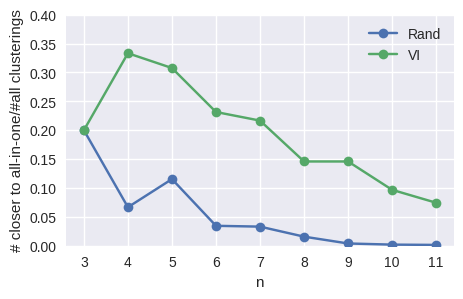

In [7]:
fig,ax=plt.subplots(figsize=(5,3))
ax.plot(result_rand[:,0],result_rand[:,2]/result_rand[:,4],"o-",label="Rand")
ax.plot(result_VI[:,0],result_VI[:,2]/result_VI[:,4],"o-",label="VI")
ax.set_ylim(0,0.4)
ax.legend()
ax.set_xlabel("n")
ax.set_ylabel("# closer to all-in-one/#all clusterings")

What we see: The proportion of clusterings that are closer to the all-in-one clustering than to the singletons clustering falls quite a lot faster for Rand distance.